In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
log_dir = '/home/lrvnc/Projects/worm-graph/logs/hydra/real_kato'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
import datetime
import os
import torch
from pkg import DEVICE
from models._utils import *
from visualize._utils import plot_heat_map

/om2/user/lrvenan/miniconda/envs/worm-graph/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


# LOSS
---

In [4]:
def plot_loss_curves(log_dir):
    """Plots the loss curves stored in a log directory.

    Args:
        log_dir (str): The path to the log directory.
    """
    
    sns.set(style='whitegrid')
    sns.set_palette("tab10")

    # process the config.yaml file inside the log folder
    cfg_path = os.path.join(log_dir, "config.yaml")
    if os.path.exists(cfg_path):
        config = OmegaConf.structured(OmegaConf.load(cfg_path))
    else:
        config = OmegaConf.structured(
            {
                "dataset": {"name": "unknown"},
                "model": {"type": "unknown"},
                "train": {"tau_in": "unknown"},
                "globals": {"timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")},
            }
        )

    # Get strings for plot title
    dataset_name = config.dataset.name
    dataset_name = dataset_name.split("_")
    dataset_name = [ds_name[:-4] for ds_name in dataset_name]
    dataset_name = ", ".join(dataset_name)
    model_name = config.model.type
    tau_in = config.train.tau_in
    timestamp = datetime.datetime.strptime(config.globals.timestamp, "%Y_%m_%d_%H_%M_%S")

    # Create the plot title
    plt_title = (
        "Model: {}\nDataset: {}\nTraining {}: {}\n{}".format(
            model_name,
            dataset_name,
            r'$\tau$',
            tau_in,
            timestamp.strftime("%Y-%m-%d %H:%M:%S"),
        )
    )

    # return if no loss curves file found
    loss_curves_csv = os.path.join(log_dir, "loss_curves.csv")
    if not os.path.exists(loss_curves_csv):
        print("No loss curves found in log directory.")
        return None
    
    # load the loss dataframe
    loss_df = pd.read_csv(loss_curves_csv, index_col=0)

    # plot loss vs epochs
    plt.figure(figsize=(10, 6))

    sns.lineplot(
        x="epochs",
        y="train_losses",
        data=loss_df,
        label="Original train",
        color="c",
        alpha=0.8,
        **dict(linestyle=":"),
    )

    sns.lineplot(
        x="epochs",
        y="test_losses",
        data=loss_df,
        label="Original test",
        color="r",
        alpha=0.8,
        **dict(linestyle=":"),
    )
    sns.lineplot(x="epochs", y="centered_train_losses", data=loss_df, label="Centered train")
    sns.lineplot(x="epochs", y="centered_test_losses", data=loss_df, label="Centered test")
    plt.legend(frameon=True, loc="upper right", fontsize=12)

    plt.title('Loss curves', fontsize=16)
    
    # After creating your subplots and setting their titles, adjust the plot layout

    y = min(loss_df['centered_test_losses'].min(), loss_df['centered_train_losses'].min(), loss_df['train_losses'].min(), loss_df['test_losses'].min())
    plt.text(0, y, plt_title, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), style='italic')
    plt.xlabel("Epoch (# worm cohorts)")
    plt.ylabel("Loss - Baseline")
    plt.tight_layout(pad=0.5)
    #plt.savefig(os.path.join(log_dir, "loss_curves.png"))
    #plt.close()
    return None

In [5]:
plot_loss_curves(log_dir)

AttributeError: module 'datetime' has no attribute 'now'

# WEIGHTS
---

In [6]:
def load_checkpoints(log_dir):
    """Loads the checkpoint stored in a log directory.

    Args:
        log_dir (str): The path to the log directory.
    """
    
    # Process the config.yaml file inside the log folder
    cfg_path = os.path.join(log_dir, "config.yaml")
    if os.path.exists(cfg_path):
        config = OmegaConf.structured(OmegaConf.load(cfg_path))
    else:
        config = OmegaConf.structured(
            {
                "dataset": {"name": "unknown"},
                "model": {"type": "unknown"},
                "train": {"tau_in": "unknown"},
                "globals": {"timestamp": datetime.now().strftime("%Y_%m_%d_%H_%M_%S")},
            }
        )

    # If no checkpoints found
    chkpt_dir = os.path.join(log_dir, "checkpoints")
    assert os.path.exists(chkpt_dir), "No checkpoints found in log directory."

    # Checkpoint files
    chkpts = sorted(os.listdir(chkpt_dir), key=lambda x: int(x.split("_")[0]))

    models = [] # List of models with their corresponding checkpoints
    
    for chkpt in chkpts:

        # Load the checkpoint
        chkpt = os.path.join(chkpt_dir, chkpt)
        chkpt = torch.load(chkpt, map_location=DEVICE)

        # Create the model to load the weights into
        input_size, hidden_size, num_layers = (
            chkpt["input_size"],
            chkpt["hidden_size"],
            chkpt["num_layers"],
        )

        loss_name = chkpt["loss_name"]

        fft_reg_param, l1_reg_param = (
            chkpt["fft_reg_param"],
            chkpt["l1_reg_param"],
        )

        model = eval(config.model.type)(
            input_size,
            hidden_size,
            num_layers,
            loss=loss_name,
            fft_reg_param=fft_reg_param,
            l1_reg_param=l1_reg_param,
        )

        # Load the weights
        model.load_state_dict(chkpt["model_state_dict"])
        model.eval()
        
        models.append(model)

    return models, chkpts

In [7]:
models, checkpoints = load_checkpoints(log_dir)

In [8]:
def get_layers_and_weights(model):
    """
    Prints the name of layers in a model that have weights.

    Args:
        model (nn.Module): PyTorch model.

    Returns:
        layers_with_weights (List[str]): List of names of layers with weights.
    """
    layers_with_weights = [(name, param.detach().numpy()) for name, param in model.named_parameters()]
    
    return layers_with_weights

In [9]:
def plot_single_weight_distribution(weights, layer_name, ax, ylabel=True):
    """Plots the weights of a specific layer in the model."""

    # Flatten the weights to have them in one dimension
    weights = weights.flatten()

    # Calculate the range for x-axis limits
    max_abs_val = max(abs(weights.min()), abs(weights.max()))

    # Create a histogram of weights centered at zero
    sns.histplot(data=weights, bins='auto', color='c', edgecolor='k', alpha=0.65, stat='percent', ax=ax)
    
    # Set x-axis limits to center the histogram at zero
    ax.set_xlim(-max_abs_val, max_abs_val)
    
    ax.set_title(f'{layer_name} distribution', fontsize=14)
    ax.set_xlabel('Weight value', fontsize=12)

    if not ylabel:
        ax.set_ylabel(' ')

In [10]:
def plot_checkopoint_weight_distribution(log_dir, checkpoints=None):

	# Process the config.yaml file inside the log folder
	cfg_path = os.path.join(log_dir, "config.yaml")
	if os.path.exists(cfg_path):
		config = OmegaConf.structured(OmegaConf.load(cfg_path))
	else:
		config = OmegaConf.structured(
			{
				"dataset": {"name": "unknown"},
				"model": {"type": "unknown"},
				"train": {"tau_in": "unknown"},
				"globals": {"timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")},
			}
		)

	# Get strings for plot title
	dataset_name = config.dataset.name
	dataset_name = dataset_name.split("_")
	dataset_name = [ds_name[:-4] for ds_name in dataset_name]
	dataset_name = ", ".join(dataset_name)
	model_name = config.model.type
	tau_in = config.train.tau_in
	timestamp = datetime.datetime.strptime(config.globals.timestamp, "%Y_%m_%d_%H_%M_%S")

	# Create the plot title
	model_info = (
		"Model: {} ~ Dataset: {} ~ Training {}: {} ~ {}".format(
			model_name,
			dataset_name,
			r'$\tau$',
			tau_in,
			timestamp.strftime("%Y-%m-%d %H:%M:%S"),
		)
	)

	models, chkpt_names = load_checkpoints(log_dir)

	if checkpoints is None:
		iterable_models = [models[0], models[-1]] # First and last checkpoints
		iterable_chkpt_names = [chkpt_names[0], chkpt_names[-1]]
	else:
		assert isinstance(checkpoints, list), "Checkpoints must be a list of integers."
		iterable_models = [models[i] for i in checkpoints]
		iterable_chkpt_names = [chkpt_names[i] for i in checkpoints]

	for chkpt, model in zip(iterable_chkpt_names, iterable_models):
			layers = get_layers_and_weights(model)

			ncols = 2
			nrows = int(np.ceil(len(layers) / ncols))

			fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))


			for i, (layer_name, weights) in enumerate(layers):
				row = i // ncols
				col = i % ncols

				if col == 1:
						ylabel = False
				else:
					ylabel = True

				plot_single_weight_distribution(weights, layer_name, axes[row, col], ylabel=ylabel)

			chkpt = chkpt.split('_')
			epoch, num_worms = chkpt[0], chkpt[-2]
			chkpt = '{} epochs ({} worm)\n'.format(epoch, num_worms) + model_info

			fig.suptitle('Weight distributions at: {}'.format(chkpt), fontsize=16, fontstyle='italic')
			plt.tight_layout(pad=0.5)
			plt.subplots_adjust(top=0.935)
			filename = 'weight_distribution_epoch_{}.png'.format(epoch)
			plt.savefig(os.path.join(log_dir, filename))
			plt.close()

In [11]:
plot_checkopoint_weight_distribution(log_dir)

In [12]:
def plot_checkpoint_weights(log_dir, checkpoints=None):

	# Process the config.yaml file inside the log folder
	cfg_path = os.path.join(log_dir, "config.yaml")
	if os.path.exists(cfg_path):
		config = OmegaConf.structured(OmegaConf.load(cfg_path))
	else:
		config = OmegaConf.structured(
			{
				"dataset": {"name": "unknown"},
				"model": {"type": "unknown"},
				"train": {"tau_in": "unknown"},
				"globals": {"timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")},
			}
		)

	# Get strings for plot title
	dataset_name = config.dataset.name
	dataset_name = dataset_name.split("_")
	dataset_name = [ds_name[:-4] for ds_name in dataset_name]
	dataset_name = ", ".join(dataset_name)
	model_name = config.model.type
	tau_in = config.train.tau_in
	timestamp = datetime.datetime.strptime(config.globals.timestamp, "%Y_%m_%d_%H_%M_%S")

	# Create the plot title
	model_info = (
		"Model: {} ~ Dataset: {} ~ Training {}: {} ~ {}".format(
			model_name,
			dataset_name,
			r'$\tau$',
			tau_in,
			timestamp.strftime("%Y-%m-%d %H:%M:%S"),
		)
	)

	models, chkpt_names = load_checkpoints(log_dir)

	if checkpoints is None:
		iterable_models = [models[0], models[-1]] # First and last checkpoints
		iterable_chkpt_names = [chkpt_names[0], chkpt_names[-1]]
	else:
		assert isinstance(checkpoints, list), "Checkpoints must be a list of integers."
		iterable_models = [models[i] for i in checkpoints]
		iterable_chkpt_names = [chkpt_names[i] for i in checkpoints]

	for chkpt, model in zip(iterable_chkpt_names, iterable_models):
		
		layers_and_weights = get_layers_and_weights(model)
		layers_with_weights = [layer for layer in layers_and_weights if 'weight' in layer[0]]

		ncols = 2
		nrows = int(np.ceil(len(layers_with_weights)/2))

		fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))

		for i, (layer_name, weights) in enumerate(layers_with_weights):
			
			row = i // ncols
			col = i % ncols
			
			plot_heat_map(weights, axes[row, col], show_xticks=False, show_yticks=False, title=layer_name, cmap='coolwarm', center=0.0)

		# Delete last subplot if there is an odd number of subplots
		if len(layers_with_weights) % 2 != 0:
			fig.delaxes(axes[row, col+1])
		
		chkpt = chkpt.split('_')
		epoch, num_worms = chkpt[0], chkpt[-2]
		chkpt = '{} epochs ({} worm)\n'.format(epoch, num_worms) + model_info

		fig.suptitle('Weight distributions at: {}'.format(chkpt), fontsize=16, fontstyle='italic')
		plt.subplots_adjust(top=1.0, bottom=0.01, left=0.03, right=1.0)
		plt.subplots_adjust(top=0.9)
		filename = 'weights_epoch_{}.png'.format(epoch)
		plt.savefig(os.path.join(log_dir, filename))
		plt.close()

In [13]:
plot_checkpoint_weights(log_dir)

In [93]:
import matplotlib.animation as animation

def animate_checkpoint_weights(log_dir, checkpoints=None):
	# Process the config.yaml file inside the log folder
	cfg_path = os.path.join(log_dir, "config.yaml")
	if os.path.exists(cfg_path):
		config = OmegaConf.structured(OmegaConf.load(cfg_path))
	else:
		config = OmegaConf.structured(
			{
				"dataset": {"name": "unknown"},
				"model": {"type": "unknown"},
				"train": {"tau_in": "unknown"},
				"globals": {"timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")},
			}
		)

	# Get strings for plot title
	dataset_name = config.dataset.name
	dataset_name = dataset_name.split("_")
	dataset_name = [ds_name[:-4] for ds_name in dataset_name]
	dataset_name = ", ".join(dataset_name)
	model_name = config.model.type
	tau_in = config.train.tau_in
	timestamp = datetime.datetime.strptime(config.globals.timestamp, "%Y_%m_%d_%H_%M_%S")

	# Create the plot title
	model_info = (
		"Model: {} ~ Dataset: {} ~ Training {}: {} ~ {}".format(
			model_name,
			dataset_name,
			r'$\tau$',
			tau_in,
			timestamp.strftime("%Y-%m-%d %H:%M:%S"),
		)
	)

	# Get the models from checkpoints
	models, chkpt_names = load_checkpoints(log_dir)

	if checkpoints is None:
		iterable_models = [models[0], models[-1]] # First and last checkpoints
		iterable_chkpt_names = [chkpt_names[0], chkpt_names[-1]]
	else:
		assert isinstance(checkpoints, list), "Checkpoints must be a list of integers."
		iterable_models = [models[i] for i in checkpoints]
		iterable_chkpt_names = [chkpt_names[i] for i in checkpoints]

	# Define the plot
	layers_and_weights = get_layers_and_weights(models[0])
	layers_with_weights = [layer for layer in layers_and_weights if 'weight' in layer[0]]

	ncols = 2
	nrows = int(np.ceil(len(layers_with_weights)/2))

	fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))

	# Create the initialization function
	def init():
		for ax in axes.flatten():
			ax.clear()

	cbar_list = []

	# Define the animation function
	def animate(i):
		# Clear colorbars
		for cbar in cbar_list:
			cbar.remove()
		cbar_list.clear()

		for ax in axes.flatten():
			ax.clear()

		model = iterable_models[i]
		chkpt = iterable_chkpt_names[i]

		layers_and_weights = get_layers_and_weights(model)
		layers_with_weights = [layer for layer in layers_and_weights if 'weight' in layer[0]]

		for j, (layer_name, weights) in enumerate(layers_with_weights):
			row = j // ncols
			col = j % ncols
			_, cbar = plot_heat_map(weights, axes[row, col], show_xticks=False, show_yticks=False, title=layer_name, cmap='coolwarm', center=0.0)
			cbar_list.append(cbar)

		# Make the last subplot invisible if there is an odd number of subplots
		if len(layers_with_weights) % 2 != 0:
			axes[row, col+1].axis('off')
			

		chkpt = chkpt.split('_')
		epoch, num_worms = chkpt[0], chkpt[-2]
		chkpt = '{} epochs ({} worm)\n'.format(epoch, num_worms) + model_info

		fig.suptitle('Weight distributions at: {}'.format(chkpt), fontsize=16, fontstyle='italic')
		plt.subplots_adjust(top=1.0, bottom=0.01, left=0.03, right=0.94)
		plt.subplots_adjust(top=0.9)
	
	# Create the animation
	ani = animation.FuncAnimation(fig, animate, frames=len(iterable_models), init_func=init, interval=500, blit=False)

	# Save the animation
	filename = 'weights_evolution.mp4'
	ani.save(filename)

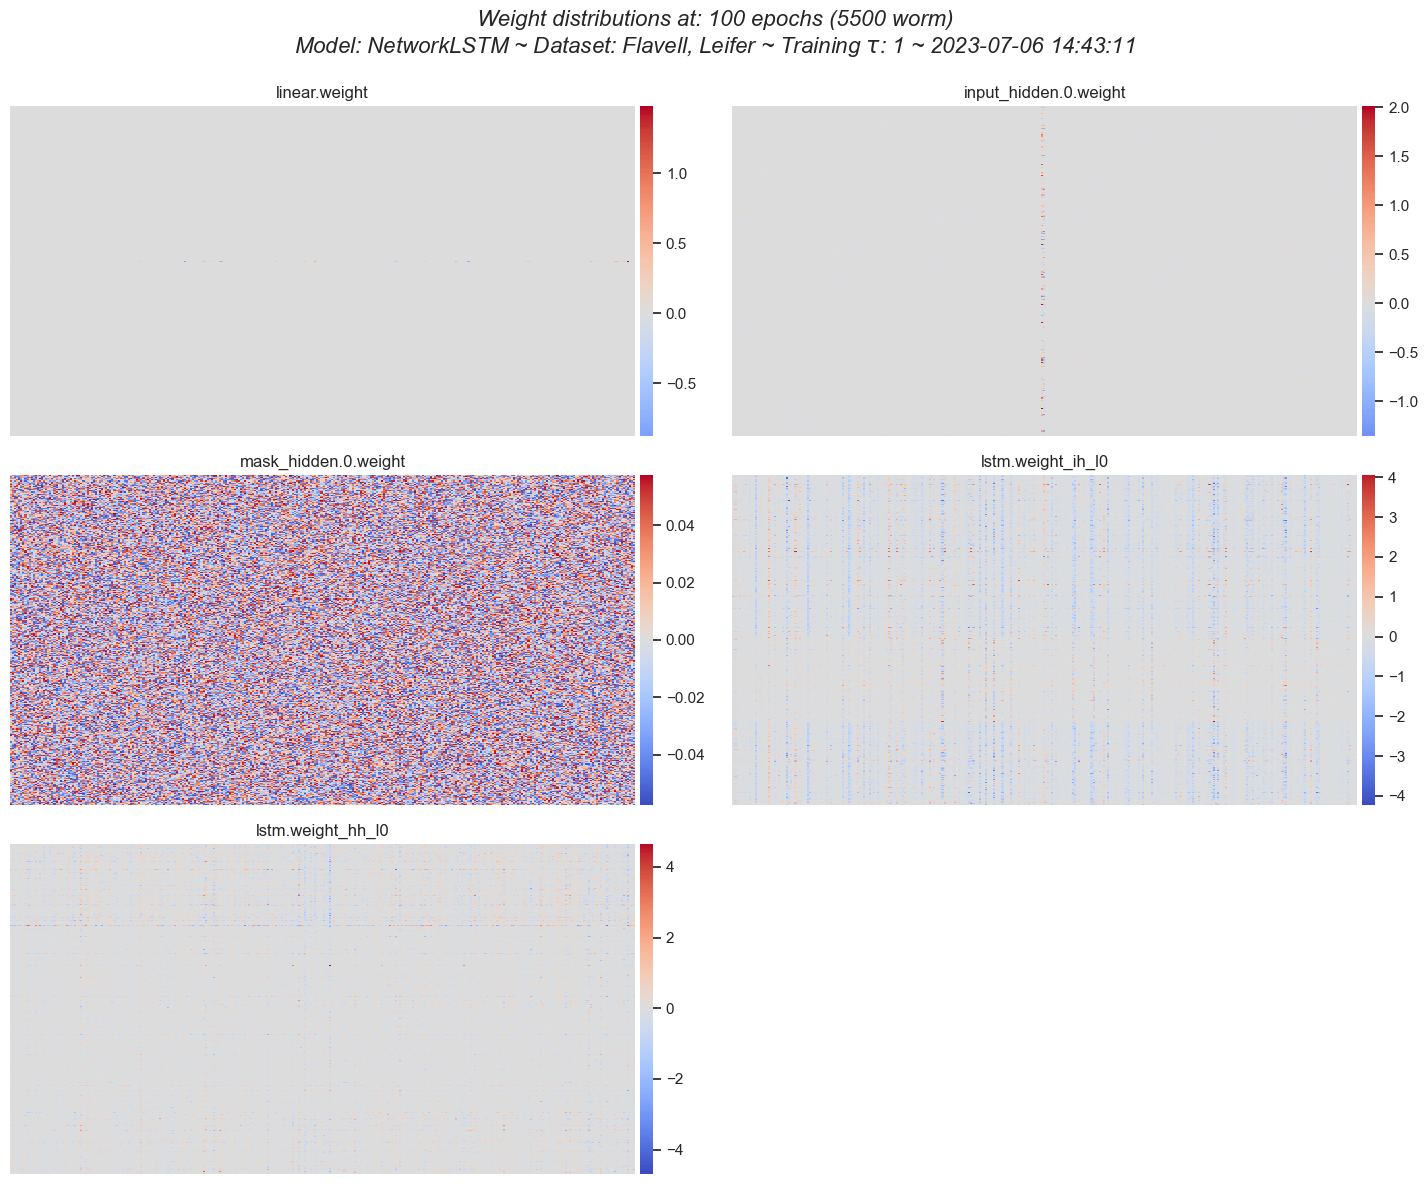

In [94]:
animate_checkpoint_weights(log_dir, checkpoints=[0, 1, 2, 3, 4])

# PREDICTIONS
---

In [9]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [26]:
from utils import NEURONS_302

def plot_targets_predictions(
    log_dir: str,
    worm: Union[str, None] = "worm0",
    neuron: Union[str, None] = "ADAL",
    use_residual: bool = False,
) -> None:
    """
    Plot of the target calcium or calcium residual time series overlayed
    with the predicted calcium or calcium residual time series of a single
    neuron in a given worm.
    """
    # Whether using residual or calcium signal
    signal_str = "residual" if use_residual else "calcium"

    # Process the config.yaml file inside the log folder
    cfg_path = os.path.join(log_dir, "config.yaml")
    if os.path.exists(cfg_path):
        config = OmegaConf.structured(OmegaConf.load(cfg_path))
    else:
        config = OmegaConf.structured(
            {
                "dataset": {"name": "unknown"},
                "model": {"type": "unknown"},
                "train": {"tau_in": "unknown"},
                "predict": {"tau_out": "unknown", "dataset": {"name": "unknown"}},
                "globals": {"timestamp": datetime.now().strftime("%Y_%m_%d_%H_%M_%S")},
            }
        )

    # Get strings for plot title
    train_dataset_name = config.dataset.name
    train_dataset_name = train_dataset_name.split("_")
    train_dataset_name = [ds_name[:-4] for ds_name in train_dataset_name]
    train_dataset_name = ", ".join(train_dataset_name)

    predict_dataset_name = config.predict.dataset.name
    predict_dataset_name = predict_dataset_name.split("_")
    predict_dataset_name = [ds_name[:-4] for ds_name in predict_dataset_name]
    predict_dataset_name = ", ".join(predict_dataset_name)

    model_name = config.model.type
    tau_in = config.train.tau_in
    tau_out = config.predict.tau_out
    timestamp = datetime.datetime.strptime(config.globals.timestamp, "%Y_%m_%d_%H_%M_%S")
    
    # Recursive call for all worms
    if (worm is None) or (worm.lower() == "all"):
        all_worms = [fname for fname in os.listdir(log_dir) if fname.startswith("worm")]
        for _worm_ in all_worms:
            plot_targets_predictions(log_dir, _worm_, neuron)
        return None
    else:
        assert worm in set(os.listdir(log_dir)), "No data for requested worm found."

    # Return if no targets or predicitions files found
    predictions_csv = os.path.join(log_dir, worm, "predicted_" + signal_str + ".csv")
    targets_csv = os.path.join(log_dir, worm, "target_" + signal_str + ".csv")
    if (not os.path.exists(predictions_csv)) or (not os.path.exists(targets_csv)):
        print("No targets or predictions found in log directory.")
        return None
    # Load predictions dataframe
    predictions_df = pd.read_csv(predictions_csv, index_col=0)
    tau_out = predictions_df["tau"][0]
    # Load targets dataframe
    targets_df = pd.read_csv(targets_csv, index_col=0)

    # Plot helper
    def func(_neuron_):
        os.makedirs(os.path.join(log_dir, worm, "figures"), exist_ok=True)
        
        # Create the plot title
        plt_title = (
            "Model: {}\nTrain dataset: {}\nPredict dataset: {}\nWorm index: {}\nTraining {}: {}\nPrediction {}: {}".format(
                model_name,
                train_dataset_name,
                predict_dataset_name,
                worm,
                r'$\tau$',
                tau_in,
                r'$\tau$',
                tau_out,
                timestamp.strftime("%Y-%m-%d %H:%M:%S"),
            )
        )

        # Create a figure with a larger size. Adjust (8, 6) as per your need.
        fig, ax = plt.subplots(figsize=(10, 4))
        
        # Use sns whitegrid style
        sns.set_style("whitegrid")
        # Use palette tab10
        sns.set_palette("tab10")

        sns.lineplot(
            data=targets_df,
            x=targets_df.time_in_seconds,
            y=targets_df[_neuron_],
            label="Target",
            color=sns.color_palette("tab10")[3], #red
            alpha=0.3,
            linewidth=2.5,
            ax=ax,
        )

        sns.lineplot(
            data=predictions_df,
            x=targets_df.time_in_seconds,
            y=predictions_df[_neuron_],
            color=sns.color_palette("tab10")[0], #blue
            label="Prediction",
            alpha=0.9,
            linewidth=1,
            ax=ax,
        )

        ylo, yhi = ax.get_ylim()

        ax.fill_between(
            targets_df.time_in_seconds,
            ylo,
            yhi,
            where=predictions_df["train_test_label"] == "train",
            alpha=0.1,
            facecolor=sns.color_palette("tab10")[9],
            label="Train stage",
        )

        ax.fill_between(
            targets_df.time_in_seconds,
            ylo,
            yhi,
            where=predictions_df["train_test_label"] == "test",
            alpha=0.1,
            facecolor=sns.color_palette("tab10")[6], #green
            label="Test stage",
        )

        ax.fill_between(
            targets_df.time_in_seconds.to_numpy()[-tau_out:],
            ylo,
            yhi,
            alpha=0.1,
            facecolor=sns.color_palette("tab10")[8], #yellow/green
            label="Prediction stage",
        )

        ax.legend(loc="upper left", fontsize=6)
        
        # Adjust the plot layout
        y = min(targets_df[_neuron_].min(), predictions_df[_neuron_].min())
        plt.text(0, y, plt_title, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), style='italic')
        plt.title("Neural activity: {} (GCaMP fluorescence) - {}".format(signal_str, _neuron_))

        plt.xlabel("Time (s)")
        plt.ylabel(signal_str.capitalize() + " ($\Delta F / F$)")
        #plt.savefig(
        #    os.path.join(log_dir, worm, "figures", signal_str + "_%s.png" % _neuron_)
        #)
        #plt.close()
        return None

    # plot predictions for neuron(s)
    columns = set(predictions_df.columns)
    if (neuron is None) or (neuron.lower() == "all"):
        for _neuron_ in set(NEURONS_302) & columns:
            func(_neuron_)
    elif neuron in columns:
        func(neuron)
    else:
        pass  # do nothing
    return None

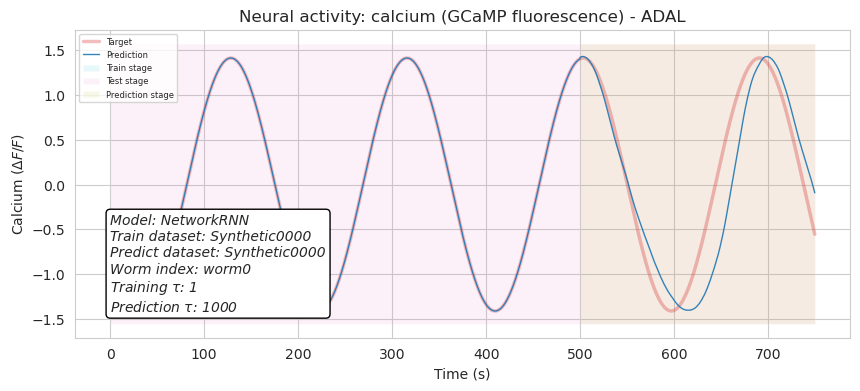

In [27]:
plot_targets_predictions('/om2/user/lrvenan/worm-graph/logs/hydra/sines1_same')

# REAL DATA
---

In [2]:
def plot_signals(data, time_tensor, neuron_idx=None, yax_limit=True, suptitle=None):
    assert isinstance(data, torch.Tensor), "data must be a PyTorch tensor"
    assert isinstance(time_tensor, torch.Tensor), "time_tensor must be a PyTorch tensor"
    assert data.dim() == 2, "data must be a 2D tensor"
    assert isinstance(neuron_idx, (int, list)), "neuron_idx must be an integer or list"

    time_tensor = time_tensor.squeeze()
    assert data.size(0) == time_tensor.size(0), "Number of rows in data and time_tensor must match"
    
    num_neurons = data.size(1)
    
    # Randomly select the column indices if not provided
    if isinstance(neuron_idx, int):
        assert neuron_idx <= num_neurons, "neuron_idx cannot exceed the number of neurons"
        column_indices = np.random.choice(num_neurons, neuron_idx, replace=False)
    elif isinstance(neuron_idx, list):
        assert len(neuron_idx) <= num_neurons, "neuron_idx cannot exceed the number of neurons"
        column_indices = np.array(neuron_idx)

    num_columns = len(column_indices)
    
    # Extract the selected columns from the data tensor
    selected_columns = data[:, column_indices]
    
    # Define the color palette using scientific colors
    colors = sns.color_palette("bright", num_columns)
    
    # Plotting subplots vertically
    fig, axs = plt.subplots(num_columns, 1, figsize=(15,num_columns))
    fig.tight_layout(pad=0.0)
    
    for i, ax in enumerate(axs):
        ax.plot(time_tensor, selected_columns[:, i], color=colors[i])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        if yax_limit:
            ax.set_ylim(-1.0, 1.0)
        ax.set_ylabel("{}".format(NEURONS_302[column_indices[i]]))
        
        if i < num_columns - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel("Time")

    # Add a super title to the figure if provided
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(pad=1)
    
    plt.show()

In [37]:
from data._main import get_dataset
from utils import NEURONS_302
from omegaconf import OmegaConf

dataset = get_dataset(
    OmegaConf.create({"dataset": {"name": "Kato2015", "leave_out_worms": []}})
)

Chosen dataset(s): ['Kato2015']
Num. worms: 12



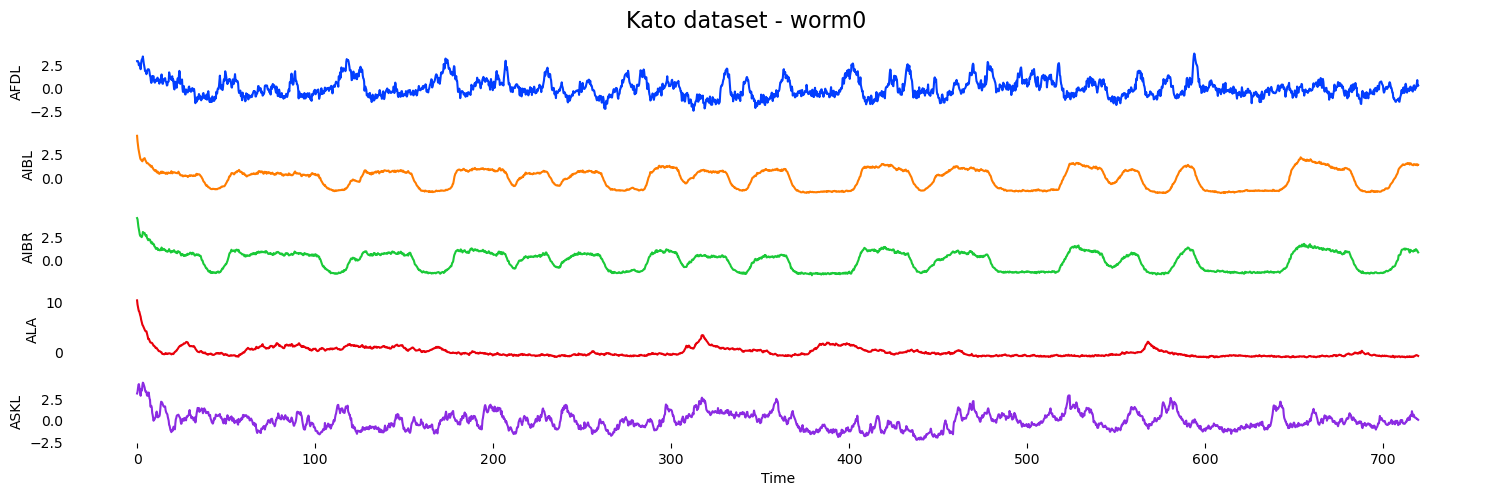

In [38]:
worm_idx = "worm0"

neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()]
neuron_idx = neuron_idx[:5]

plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Kato dataset - {}".format(worm_idx),
)